<a href="https://colab.research.google.com/github/sul01/MSDS-CODE/blob/master/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Packages

In [21]:
import pandas as pd
import numpy as np
import functools
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Data Set

In [22]:
BITSTREAMVERA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/BITSTREAMVERA.csv")

CONSOLAS = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/CONSOLAS.csv")

EBRIMA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/EBRIMA.csv")

Cleaning and Sorting

In [23]:
drop_names = ["fontVariant", "m_label", "orientation", "m_top", "m_left", "originalH", "originalW", "h", "w"]

CL1 = BITSTREAMVERA.dropna()

CL1.drop(columns = drop_names, inplace = True)

CL1.drop(CL1[(CL1["strength"] != 0.4) | (CL1["italic"] != 0)].index, inplace = True)

CL2 = CONSOLAS.dropna()

CL2.drop(columns = drop_names, inplace = True)

CL2.drop(CL2[(CL2["strength"] != 0.4) | (CL2["italic"] != 0)].index, inplace = True)

CL3 = EBRIMA.dropna()

CL3.drop(columns = drop_names, inplace = True)

CL3.drop(CL3[(CL3["strength"] != 0.4) | (CL3["italic"] != 0)].index, inplace = True)

DATA = pd.concat([CL1, CL2, CL3], ignore_index=True)

Standardize

In [24]:
for cl in [CL1, CL2, CL3]:
    cl[cl.columns[3:]] = pd.DataFrame(StandardScaler().fit_transform(cl[cl.columns[3:]]))
SDATA = pd.concat([CL1,CL2,CL3], ignore_index=True)

correlation matrix

In [ ]:
CORR = DATA[3:].corr()

#re-classifying the new data

define test&training sets

In [25]:
#create train/test set
train, test = train_test_split(SDATA, test_size=0.2, random_state=0)
x_train = train.drop(['font','strength','italic'], axis=1)
x_test = test.drop(['font','strength','italic'], axis=1)
y_train = train['font']
y_test = test['font']

#finding H0 and H*

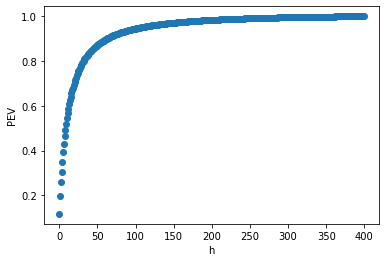

BITSTREAMVERA 



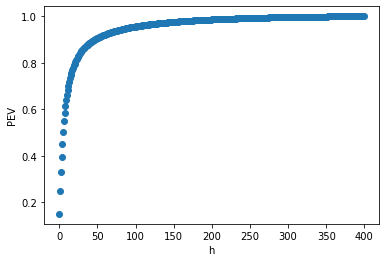

CONSOLAS 



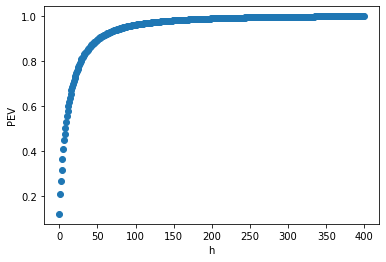

EBRIMA 



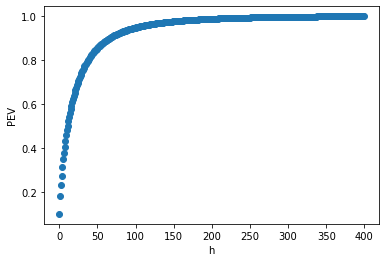

In [26]:
#H0:
pca = PCA(n_components=400)
pca.fit_transform(SDATA[SDATA.columns[3:]])
pev = pca.explained_variance_ratio_.cumsum()
h0 = np.where(pev>=0.95)[0][0]+1
plt.plot(pev, 'o'); plt.ylabel('PEV'); plt.xlabel('h'); plt.show() #plot PVE

#H*:
hi = []
for i in [CL1, CL2, CL3]:
  pca = PCA(n_components=400)
  pca.fit_transform(i[i.columns[3:]])
  pev = pca.explained_variance_ratio_.cumsum()
  hi.append(np.where(pev>=0.99)[0][0]+1)
  print(i['font'][0],'\n')
  plt.plot(pev, 'o'); plt.ylabel('PEV'); plt.xlabel('h'); plt.show() #plot PVE
h_star = sum(hi)

MLP0

MLP0:



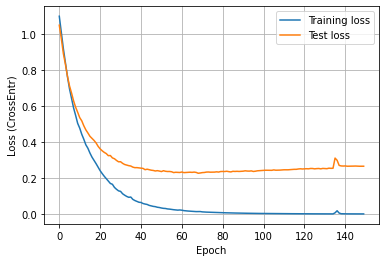

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import load_model
tf.get_logger().setLevel('ERROR') #surpress logging 

def plotPerf(monitor):
  plt.plot(monitor.model.history.history['loss'], label='Training loss')
  plt.plot(monitor.model.history.history['val_loss'], label='Test loss')
  plt.xlabel('Epoch'); plt.ylabel('Loss (CrossEntr)')
  plt.legend(); plt.grid(True); plt.show()

def ypred(x, model):
  return list(map({0:'BITSTREAMVERA', 1:'CONSOLAS', 2:'EBRIMA'}.get, model.predict(x).argmax(axis=-1)))

def conf(actu, pred):
  y_actu = pd.Series(np.array(actu), name='Actual')
  y_pred = pd.Series(pred, name='Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion/ df_confusion.sum()

inputs = keras.Input(shape=(400,))
x1 = layers.Dense(h0,activation="sigmoid")(inputs)
outputs = layers.Dense(3, activation="softmax")(x1)
model0 = keras.Model(inputs=inputs,outputs=outputs)
#model0.summary()

optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model0.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
batch = round(len(train)**0.5)

Monitor0 = model0.fit(x_train,y_train.astype('category').cat.codes,epochs=150, batch_size=batch,
                      validation_data=(x_test,y_test.astype('category').cat.codes), verbose=0)

print('MLP0:\n')
plotPerf(Monitor0) #visually find stabT, overfitT, stopT


Confusion Matrices for StabT

In [29]:
stabT = 45

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == stabT:
            self.model.save("modelh0_{}".format(epoch))
checkpoint = CustomSaver()

inputs = keras.Input(shape=(400,))
x1 = layers.Dense(h0,activation="sigmoid")(inputs)
outputs = layers.Dense(3, activation="softmax")(x1)
model0 = keras.Model(inputs=inputs,outputs=outputs)
model0.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
model0.fit(x_train,y_train.astype('category').cat.codes,epochs=stabT+1, batch_size=batch,
                      validation_data=(x_test,y_test.astype('category').cat.codes),callbacks=[checkpoint], verbose=0)
model0_stab = load_model("modelh0_{}".format(stabT))

trainConf0 = conf(y_train, ypred(x_train, model0_stab))
print('MLP0 train:\n', trainConf0)
testConf0 = conf(y_test, ypred(x_test, model0_stab))
print('\nMLP0 test:\n', testConf0)

MLP0 train:
 Predicted      BITSTREAMVERA  CONSOLAS    EBRIMA
Actual                                          
BITSTREAMVERA       0.987568  0.002668  0.003033
CONSOLAS            0.010270  0.845784  0.159212
EBRIMA              0.002162  0.151547  0.837756

MLP0 test:
 Predicted      BITSTREAMVERA  CONSOLAS    EBRIMA
Actual                                          
BITSTREAMVERA       0.974194  0.008147  0.009836
CONSOLAS            0.010753  0.729124  0.354098
EBRIMA              0.015054  0.262729  0.636066


MLP*

MLP* TAR=10%:



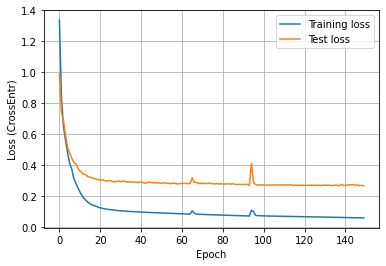



MLP* TAR=20%:



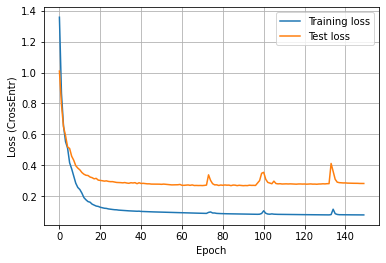

In [31]:
#define sparsity regularization layer
class SparsityRegularizationLayer(layers.Layer):
  def __init__(self, C=0.01, Tar=0.01, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.Tar = Tar
  def call(self, inputs):
    avAL = tf.reduce_mean(inputs)
    self.add_loss(  self.C * (  -1*self.Tar*tf.math.log(avAL) + (self.Tar-1)*tf.math.log(1-avAL)  )  )
    return inputs
  def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C,
            'Tar': self.Tar,
        })
        return config

#Sparsity TAR = 10%
inputs = keras.Input(shape=(400,))
x1 = layers.Dense(h_star,activation="sigmoid")(inputs)
x1 = SparsityRegularizationLayer(C=0.15, Tar = 0.1)(x1)
outputs = layers.Dense(3, activation="softmax")(x1)
modelh10 = keras.Model(inputs=inputs,outputs=outputs)
modelh10.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
Monitorh10 = modelh10.fit(x_train,y_train.astype('category').cat.codes,epochs=150, batch_size=batch,
                      validation_data=(x_test,y_test.astype('category').cat.codes), verbose=0)
print('MLP* TAR=10%:\n')
plotPerf(Monitorh10) #visually find stabT, overfitT, stopT

#Sparsity TAR = 20%
inputs = keras.Input(shape=(400,))
x2 = layers.Dense(h_star,activation="sigmoid")(inputs)
x2 = SparsityRegularizationLayer(C=0.15, Tar = 0.2)(x2)
outputs = layers.Dense(3, activation="softmax")(x2)
modelh20 = keras.Model(inputs=inputs,outputs=outputs)
modelh20.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
Monitorh20 = modelh20.fit(x_train,y_train.astype('category').cat.codes,epochs=150, batch_size=batch,
                      validation_data=(x_test,y_test.astype('category').cat.codes), verbose=0)
print('\n\nMLP* TAR=20%:\n')
plotPerf(Monitorh20) #visually find stabT, overfitT, stopT


Confusion Matrices

In [34]:
#TAR=10%
stabT1 = 45
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == stabT1:
            self.model.save("modelh10_{}".format(epoch))
checkpoint = CustomSaver()
inputs = keras.Input(shape=(400,))
x1 = layers.Dense(h_star,activation="sigmoid")(inputs)
x1 = SparsityRegularizationLayer(C=0.15, Tar = 0.1)(x1)
outputs = layers.Dense(3, activation="softmax")(x1)
modelh10 = keras.Model(inputs=inputs,outputs=outputs)
modelh10.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
modelh10.fit(x_train,y_train.astype('category').cat.codes,epochs=stabT1+1, batch_size=batch,
                      validation_data=(x_test,y_test.astype('category').cat.codes),callbacks=[checkpoint], verbose=0)
modelh10_stab = load_model("modelh10_{}".format(stabT1))

#TAR=20%
stabT2 = 45
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == stabT2:
            self.model.save("modelh20_{}".format(epoch))
checkpoint = CustomSaver()
inputs = keras.Input(shape=(400,))
x2 = layers.Dense(h_star,activation="sigmoid")(inputs)
x2 = SparsityRegularizationLayer(C=0.15, Tar = 0.2)(x2)
outputs = layers.Dense(3, activation="softmax")(x2)
modelh20 = keras.Model(inputs=inputs,outputs=outputs)
modelh20.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
modelh20.fit(x_train,y_train.astype('category').cat.codes,epochs=stabT2+1, batch_size=batch,
                      validation_data=(x_test,y_test.astype('category').cat.codes),callbacks=[checkpoint], verbose=0)
modelh20_stab = load_model("modelh20_{}".format(stabT2))

#conf matrices
print('MLP* TAR=10%:\n')
trainConfh10 = conf(y_train, ypred(x_train, modelh10_stab))
print('MLP* train:\n', trainConfh10)
testConfh10 = conf(y_test, ypred(x_test, modelh10_stab))
print('\nMLP* test:\n', testConfh10)

print('\n\nMLP* TAR=20%:\n')
trainConfh20 = conf(y_train, ypred(x_train, modelh20_stab))
print('MLP* train:\n', trainConfh20)
testConfh20 = conf(y_test, ypred(x_test, modelh20_stab))
print('\nMLP* test:\n', testConfh20)

MLP* TAR=10%:

MLP* train:
 Predicted      BITSTREAMVERA  CONSOLAS  EBRIMA
Actual                                        
BITSTREAMVERA            1.0       0.0     0.0
CONSOLAS                 0.0       1.0     0.0
EBRIMA                   0.0       0.0     1.0

MLP* test:
 Predicted      BITSTREAMVERA  CONSOLAS    EBRIMA
Actual                                          
BITSTREAMVERA       0.993506  0.000000  0.003333
CONSOLAS            0.002165  0.877756  0.106667
EBRIMA              0.004329  0.122244  0.890000


MLP* TAR=20%:

MLP* train:
 Predicted      BITSTREAMVERA  CONSOLAS  EBRIMA
Actual                                        
BITSTREAMVERA            1.0       0.0     0.0
CONSOLAS                 0.0       1.0     0.0
EBRIMA                   0.0       0.0     1.0

MLP* test:
 Predicted      BITSTREAMVERA  CONSOLAS    EBRIMA
Actual                                          
BITSTREAMVERA       0.997817     0.002  0.006601
CONSOLAS            0.002183     0.884  0.092409
EBRIM

#MLP* Activity

**(Very unsure, please check!)**

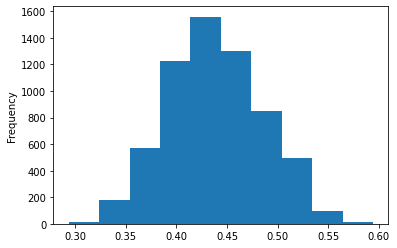

In [35]:
#performance is about the same for both sparsity levels?
modelh = modelh20_stab
activity = modelh.layers[1](np.array(SDATA[SDATA.columns[3:]])).numpy()

ACTn = np.mean(activity, axis=1)
pd.Series(ACTn).plot.hist()

avact = np.mean(ACTn)
stdact = np.std(ACTn)

per_half = sum(ACTn < avact/2)/len(ACTn)
per_third = sum(ACTn < avact/3)/len(ACTn)


#Autoencoder

PCA on zn to get size s

In [36]:
zn = modelh.layers[1](np.array(SDATA[SDATA.columns[3:]])).numpy() #Xn -> Zn:
pca = PCA(n_components=zn.shape[1])
pca.fit_transform(zn)
pev = pca.explained_variance_ratio_.cumsum()
s = np.where(pev>=0.95)[0][0]+1
#plt.plot(pev, 'o'); plt.ylabel('PEV'); plt.xlabel('s'); plt.show() #plot PVE


Build autoencoder

In [37]:
z_test = modelh.layers[1](np.array(x_test)).numpy()
z_train = modelh.layers[1](np.array(x_train)).numpy()

inputs = keras.Input(shape=(h_star,))
x1 = layers.Dense(s,activation="sigmoid")(inputs)
outputs = layers.Dense(h_star, activation="sigmoid")(x1)
autoEncoder = keras.Model(inputs=inputs,outputs=outputs)
autoEncoder.compile(optimizer=optimizer,loss=keras.losses.MeanSquaredError())

checkpoint=callbacks.ModelCheckpoint(filepath='encoder',monitor='val_loss',save_best_only=True)
Monitor = autoEncoder.fit(z_train,z_train,epochs=80, batch_size=batch,validation_data=(z_test,z_test),callbacks=[checkpoint], verbose=0)
autoEncoder = load_model('encoder')

MPL**

**(PLEASE CHECK!!)**

In [38]:
model = load_model('encoder')
#Xn -> Zn -> Kn:
kn = model.layers[1](zn).numpy()
kn_test = model.layers[1](z_test).numpy()
kn_train = model.layers[1](z_train).numpy()

#Kn -> (Out) -> P(n)
inputs = keras.Input(shape=(kn.shape[1],))
outputs = layers.Dense(3, activation="softmax")(inputs)
modelhstar2 = keras.Model(inputs=inputs,outputs=outputs)
modelhstar2.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])

checkpoint=callbacks.ModelCheckpoint(filepath='BestModel_hstar2',monitor='val_accuracy',save_best_only=True)
Monitor2 = modelhstar2.fit(kn_train,y_train.astype('category').cat.codes,epochs=150, batch_size=batch,
                      validation_data=(kn_test,y_test.astype('category').cat.codes),callbacks=[checkpoint], verbose=0)

trainConf2 = conf(y_train, ypred(kn_train, Monitor2.model))
print('MLP** train:\n', trainConf2)
testConf2 = conf(y_test, ypred(kn_test, Monitor2.model))
print('\nMLP** test:\n', testConf2)

MLP** train:
 Predicted      BITSTREAMVERA  CONSOLAS  EBRIMA
Actual                                        
BITSTREAMVERA            1.0       0.0     0.0
CONSOLAS                 0.0       1.0     0.0
EBRIMA                   0.0       0.0     1.0

MLP** test:
 Predicted      BITSTREAMVERA  CONSOLAS    EBRIMA
Actual                                          
BITSTREAMVERA       0.989177  0.001965  0.006897
CONSOLAS            0.004329  0.856582  0.113793
EBRIMA              0.006494  0.141454  0.879310
